In [43]:
# from google_drive_downloader import GoogleDriveDownloader as gdd
# gdd.download_file_from_google_drive(file_id='1TdfOz-MVrA_XP8h8oXd8IBTvOXwbFN1Y',
#                                     dest_path='/content/data.zip',
#                                     unzip=True)

In [44]:
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import copy
import os
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import sys

In [45]:
torch.cuda.is_available()

True

In [46]:
# !git clone https://github.com/sanchit2843/Videoclassification
# %cd Videoclassification

In [47]:
#Label file:
data_path = r'content\crime16'
classes = os.listdir(data_path)
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

In [48]:
id = list()
path = r'content\crime16'
for i in os.listdir(path):
  p1 = os.path.join(path,i)
  for j in os.listdir(p1):
    p2 = os.path.join(p1,j)
    id.append((i,p2))

In [49]:
class video_dataset(Dataset):
    def __init__(self,frame_list,sequence_length = 16,transform = None):
        self.frame_list = frame_list
        self.transform = transform
        self.sequence_length = sequence_length
    def __len__(self):
        return len(self.frame_list)
    def __getitem__(self,idx):
        label,path = self.frame_list[idx]
        img = cv2.imread(path)
        seq_img = list()
        for i in range(16):
          img1 = img[:,128*i:128*(i+1),:]
          if(self.transform):
            img1 = self.transform(img1)
          seq_img.append(img1)
        seq_image = torch.stack(seq_img)
        seq_image = seq_image.reshape(3,16,im_size,im_size)
        return seq_image,decoder[label]

In [50]:
im_size = 128
mean = [0.4889, 0.4887, 0.4891]
std = [0.2074, 0.2074, 0.2074]


train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

train_data = video_dataset(id,sequence_length = 16,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 8,num_workers = 0 ,shuffle = True)
dataloaders = {'train':train_loader}

In [51]:
from model import resnet50
model = resnet50(class_num=8).to('cuda')

In [52]:
from clr import *
device = 'cuda'
cls_criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9,weight_decay = 1e-4)
num_epochs = 20
onecyc = OneCycle(len(train_loader)*num_epochs,1e-3)

In [53]:
os.makedirs(r'content\drive\My Drive\weights_crime',exist_ok = True)
from torch.autograd import Variable
iteration = 0
acc_all = list()
loss_all = list()
    
for epoch in range(num_epochs):
    print('')
    print(f"--- Epoch {epoch} ---")
    phase1 = dataloaders.keys()
    for phase in phase1:
        print('')
        print(f"--- Phase {phase} ---")
        epoch_metrics = {"loss": [], "acc": []}
        for batch_i, (X, y) in enumerate(dataloaders[phase]):
            #iteration = iteration+1
            image_sequences = Variable(X.to(device), requires_grad=True)
            labels = Variable(y.to(device), requires_grad=False)
            optimizer.zero_grad()
            #model.lstm.reset_hidden_state()
            predictions = model(image_sequences)
            loss = cls_criterion(predictions, labels)
            acc = 100 * (predictions.detach().argmax(1) == labels).cpu().numpy().mean()
            loss.backward()
            optimizer.step()
            epoch_metrics["loss"].append(loss.item())
            epoch_metrics["acc"].append(acc)
            if(phase=='train'):
                lr,mom = onecyc.calc()
                update_lr(optimizer, lr)
                update_mom(optimizer, mom)
            batches_done = epoch * len(dataloaders[phase]) + batch_i
            batches_left = num_epochs * len(dataloaders[phase]) - batches_done
            sys.stdout.write(
                    "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
                    % (
                        epoch,
                        num_epochs,
                        batch_i,
                        len(dataloaders[phase]),
                        loss.item(),
                        np.mean(epoch_metrics["loss"]),
                        acc,
                        np.mean(epoch_metrics["acc"]),
                    )
                )

                # Empty cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
        print('')
        print('{} , acc: {}'.format(phase,np.mean(epoch_metrics["acc"])))
        torch.save(model.state_dict(),r'content\drive\My Drive\weights_crime\c3d_{}.h5'.format(epoch))
        if(phase=='train'):
          acc_all.append(np.mean(epoch_metrics["acc"]))
          loss_all.append(np.mean(epoch_metrics["loss"]))


--- Epoch 0 ---

--- Phase train ---
[Epoch 0/20] [Batch 53/54] [Loss: 2.728233 (1.781287), Acc: 16.67% (30.40%)]
train , acc: 30.401234567901238

--- Epoch 1 ---

--- Phase train ---
[Epoch 1/20] [Batch 53/54] [Loss: 1.674116 (1.616594), Acc: 50.00% (34.95%)]
train , acc: 34.9537037037037

--- Epoch 2 ---

--- Phase train ---
[Epoch 2/20] [Batch 53/54] [Loss: 1.063029 (1.354409), Acc: 50.00% (46.06%)]
train , acc: 46.06481481481482

--- Epoch 3 ---

--- Phase train ---
[Epoch 3/20] [Batch 53/54] [Loss: 1.076518 (1.264877), Acc: 66.67% (52.62%)]
train , acc: 52.623456790123456

--- Epoch 4 ---

--- Phase train ---
[Epoch 4/20] [Batch 53/54] [Loss: 0.360105 (0.872820), Acc: 83.33% (67.98%)]]
train , acc: 67.97839506172839

--- Epoch 5 ---

--- Phase train ---
[Epoch 5/20] [Batch 53/54] [Loss: 0.393889 (0.774343), Acc: 83.33% (77.70%)]]
train , acc: 77.7006172839506

--- Epoch 6 ---

--- Phase train ---
[Epoch 6/20] [Batch 53/54] [Loss: 0.585228 (0.565524), Acc: 83.33% (83.72%)]]
train 

In [54]:
def error_plot(loss):
    plt.figure(figsize=(10,5))
    plt.plot(loss)
    plt.title("Training loss plot")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()
def acc_plot(acc):
    plt.figure(figsize=(10,5))
    plt.plot(acc)
    plt.title("Training accuracy plot")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

In [55]:
loss_all

[1.7812867120460227,
 1.6165937185287476,
 1.3544088900089264,
 1.2648768049699288,
 0.8728197181114444,
 0.7743426994593056,
 0.5655239240645811,
 0.7107989646287428,
 0.668704725047401,
 0.4878980034738089,
 0.2326915170533876,
 0.21827404376084883,
 0.25046872436198303,
 0.06081717565083872,
 0.12097821200182403,
 0.07611446258481548,
 0.06234918381192579,
 0.0402774916074796,
 0.015272812118719567,
 0.06371200515955193]

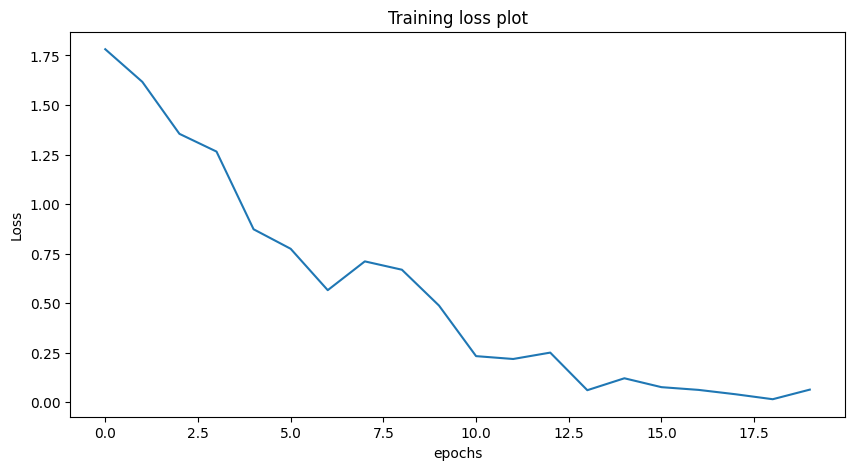

In [56]:
error_plot(loss_all)

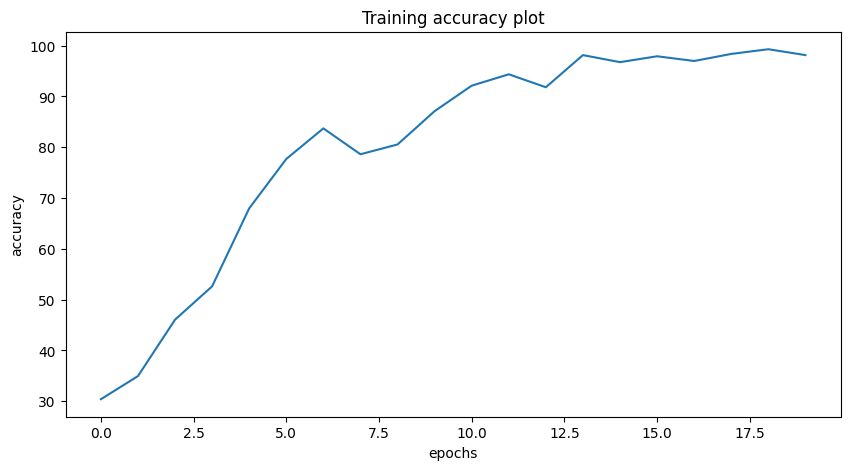

In [57]:
acc_plot(acc_all)